In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data

## NY Times

In [2]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
df = pd.read_csv(url, parse_dates=[0])  # Cols: date, state, fips, cases, deaths 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11124 entries, 0 to 11123
Data columns (total 5 columns):
date      11124 non-null datetime64[ns]
state     11124 non-null object
fips      11124 non-null int64
cases     11124 non-null int64
deaths    11124 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 434.7+ KB


The **fips** code can be used for getting the location info for the plots. Rest are self-understandable.

## Wikipedia population data

In [8]:
url = 'https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States_by_population'
pop_df = pd.read_html(url)[0]

In [9]:
pop_df.head()

Rank              State         Census population                   \
  Current 2010         State Estimate, July 1, 2019[8] April 1, 2010[9]   
0     1.0  1.0    California                  39512223         37253956   
1     2.0  2.0         Texas                  28995881         25145561   
2     3.0  4.0       Florida                  21477737         18801310   
3     4.0  3.0      New York                  19453561         19378102   
4     5.0  6.0  Pennsylvania                  12801989         12702379   

  Change, 2010–2019             Total U.S. House of Representatives Seats  \
    Percent[note 3]    Absolute Total U.S. House of Representatives Seats   
0              6.1%  +2,257,700                                        53   
1             15.3%  +3,850,320                                        36   
2             14.2%  +2,676,427                                        27   
3              0.4%     +75,459                                        27   
4              0.8%     +99,610                                        18   

  Estimated population per electoral vote, 2019[note 1]  \
  Estimated population per electoral vote, 2019[note 1]   
0                                             718404      
1                                             763050      
2                                             740611      
3                                             670812      
4                                             640099      

  Census population per House seat          \
                   Estimated, 2019    2010   
0                           745514  702885   
1                           805441  698503   
2                           795472  696468   
3                           720502  717707   
4                           711222  705715   

  Percent of the total U.S. population, 2019[note 2]  
  Percent of the total U.S. population, 2019[note 2]  
0                                             11.91%  
1                                              8.74%  
2                                              6.47%  
3                                              5.86%  
4                                              3.86%

In [10]:
pop_df = pop_df.iloc[:,2:4]
pop_df = pop_df.droplevel(0, axis=1)
pop_df.tail(10)

,State,"Estimate, July 1, 2019[8]"
50,Vermont,623989
51,Wyoming,578759
52,Guam,"168,485[10]"
53,U.S. Virgin Islands,"106,235[12]"
54,Northern Mariana Islands,"51,433[14]"
55,American Samoa,"49,437[16]"
56,Contiguous United States,325386357
57,The fifty states,327533795
58,Fifty states + D.C.,328239523
59,Total U.S. (including D.C. and territories),331808807


### Pre-processing population data

In [11]:
# Checking states names that are same before merging

s_df = set(df.state.unique())
s_pop = set(pop_df.State)

intersect = s_df.intersection(s_pop)
intersect = list(intersect)
print(f'For {len(intersect)} states, the names are common.')

print(f'\nState names in population data not common are:')
for state in s_pop.difference(intersect):
    print(state)
print(f'\nState names in COVID-19 data not common are:')
for state in s_df.difference(intersect):
    print(state)

For 54 states, the names are common.

State names in population data not common are:
Contiguous United States
Total U.S. (including D.C. and territories)
Fifty states + D.C.
American Samoa
The fifty states
U.S. Virgin Islands

State names in COVID-19 data not common are:
Virgin Islands


It's best to remove the least populous territories as they're bound to underfit and the total counts as they won't be merged eventually. With data being sorted in the correct order, the data from `pop_df` before 52nd entry is enough. Thus, keeping only data till Wyoming for this study.

In [12]:
pop_df = pop_df[:52]
pop_df.tail()

,State,"Estimate, July 1, 2019[8]"
47,North Dakota,762062
48,Alaska,731545
49,District of Columbia,705749
50,Vermont,623989
51,Wyoming,578759


In [13]:
import re
import warnings
warnings.filterwarnings("ignore")

def pre_process(total_pop):
    '''Pre-process population values where in some cases the references might 
    have '...[..]' pattern signifying reference
    '''
    try:
        num = int(total_pop)
    except:
        m = re.match(r'\d+[\d+]', total_pop)
        num = int(m.group(0))

    return num

pop_df.rename(columns={pop_df.columns[1]: 'Recent_population'}, inplace=True)

pop_df['Recent_population'] = pop_df['Recent_population'].apply(pre_process)

pop_df.sort_values(by='Recent_population')
pop_df.head()

,State,Recent_population
0,California,39512223
1,Texas,28995881
2,Florida,21477737
3,New York,19453561
4,Pennsylvania,12801989


# Pre-processing

Either merge with population data or just per day analysis

## Daily count

In [3]:
df.sort_values(by=['state', 'date'], inplace=True)

In [4]:
df.set_index('date', inplace=True)

In [5]:
df['daily_cases'] = df.groupby('state')['cases'].diff()
df['daily_cases'].fillna(df['cases'], inplace=True)

df['daily_deaths'] = df.groupby('state')['deaths'].diff()
df['daily_deaths'].fillna(df['deaths'], inplace=True)

In [17]:
df

,state,fips,cases,deaths,daily_cases,daily_deaths
date,,,,,,
2020-03-13,Alabama,1,6,0,6.0,0.0
2020-03-14,Alabama,1,12,0,6.0,0.0
2020-03-15,Alabama,1,23,0,11.0,0.0
2020-03-16,Alabama,1,29,0,6.0,0.0
2020-03-17,Alabama,1,39,0,10.0,0.0
...,...,...,...,...,...,...
2020-09-16,Wyoming,56,4566,46,128.0,0.0
2020-09-17,Wyoming,56,4652,49,86.0,3.0
2020-09-18,Wyoming,56,4747,49,95.0,0.0


## Merge with population data

Do if demographic data is needed (skipping for now)

In [14]:
data = pd.merge(pop_df, df, left_on='State', right_on='state')

In [16]:
data

,State,Recent_population,state,fips,cases,deaths,daily_cases,daily_deaths,cases_per_capita,deaths_per_capita
0,California,39512223,California,6,1,0,1.0,0.0,2.530862e-08,0.000000
1,California,39512223,California,6,2,0,1.0,0.0,5.061725e-08,0.000000
2,California,39512223,California,6,2,0,0.0,0.0,5.061725e-08,0.000000
3,California,39512223,California,6,2,0,0.0,0.0,5.061725e-08,0.000000
4,California,39512223,California,6,2,0,0.0,0.0,5.061725e-08,0.000000
...,...,...,...,...,...,...,...,...,...,...
10561,Wyoming,578759,Wyoming,56,4566,46,128.0,0.0,7.889294e-03,0.000079
10562,Wyoming,578759,Wyoming,56,4652,49,86.0,3.0,8.037888e-03,0.000085
10563,Wyoming,578759,Wyoming,56,4747,49,95.0,0.0,8.202032e-03,0.000085
10564,Wyoming,578759,Wyoming,56,4780,49,33.0,0.0,8.259051e-03,0.000085


In [15]:
data['cases_per_capita'] = data.cases / data.Recent_population
data['deaths_per_capita'] = data.deaths / data.Recent_population

data = data.drop(columns=['State', 'Recent_population']).set_index('date')

data.head()

KeyError: "None of ['date'] are in the columns"

# Analysis

Referring the great tutorial in: https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q

 ## State-wise Analysis
 
 Let's analyze the growth pattern across various states

In [6]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot

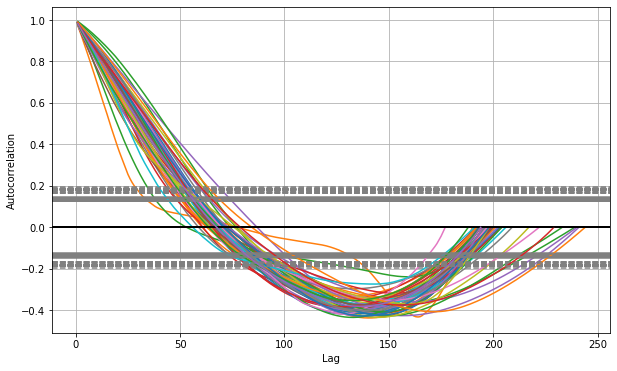

In [18]:
fig, axes = plt.subplots(1,1, figsize=(10,6))

colname = 'cases'

for i, s in enumerate(df.state.unique()):
    subset = df[df.state == s][colname]
    autocorrelation_plot(subset, ax=axes)
    
# for i, s in enumerate(data.state.unique()):
#     subset = data[data.state == s][colname]
#     autocorrelation_plot(subset, ax=axes)

The auto-correlation is obviously very high. At a lag of 10, the auto-correlation is above 0.75 for all states. We can confirm this with a lag plot for all states

In [44]:
def plot_fn(colname, plot_type, **kwargs):
    # 13 rows and 4 cols
    fig, axes = plt.subplots(nrows=13, ncols=4, sharex=kwargs['sharex'], constrained_layout=True,
                             sharey=kwargs['sharex'], figsize=(15,45))
    
    for i, s in enumerate(data.state.unique()):
        r, c = i//4, i%4
        subset = data[data.state == s][colname]
        if plot_type=='autocorr':
            autocorrelation_plot(subset, ax=axes[r,c])
            axes[r,c].set_title(s)
            
        if plot_type=='lag':
            lag = kwargs['lag']
            lag_plot(subset, lag=lag, ax=axes[r,c])
            axes[r,c].set_title(f'Lag: {lag} for {s}')
                                

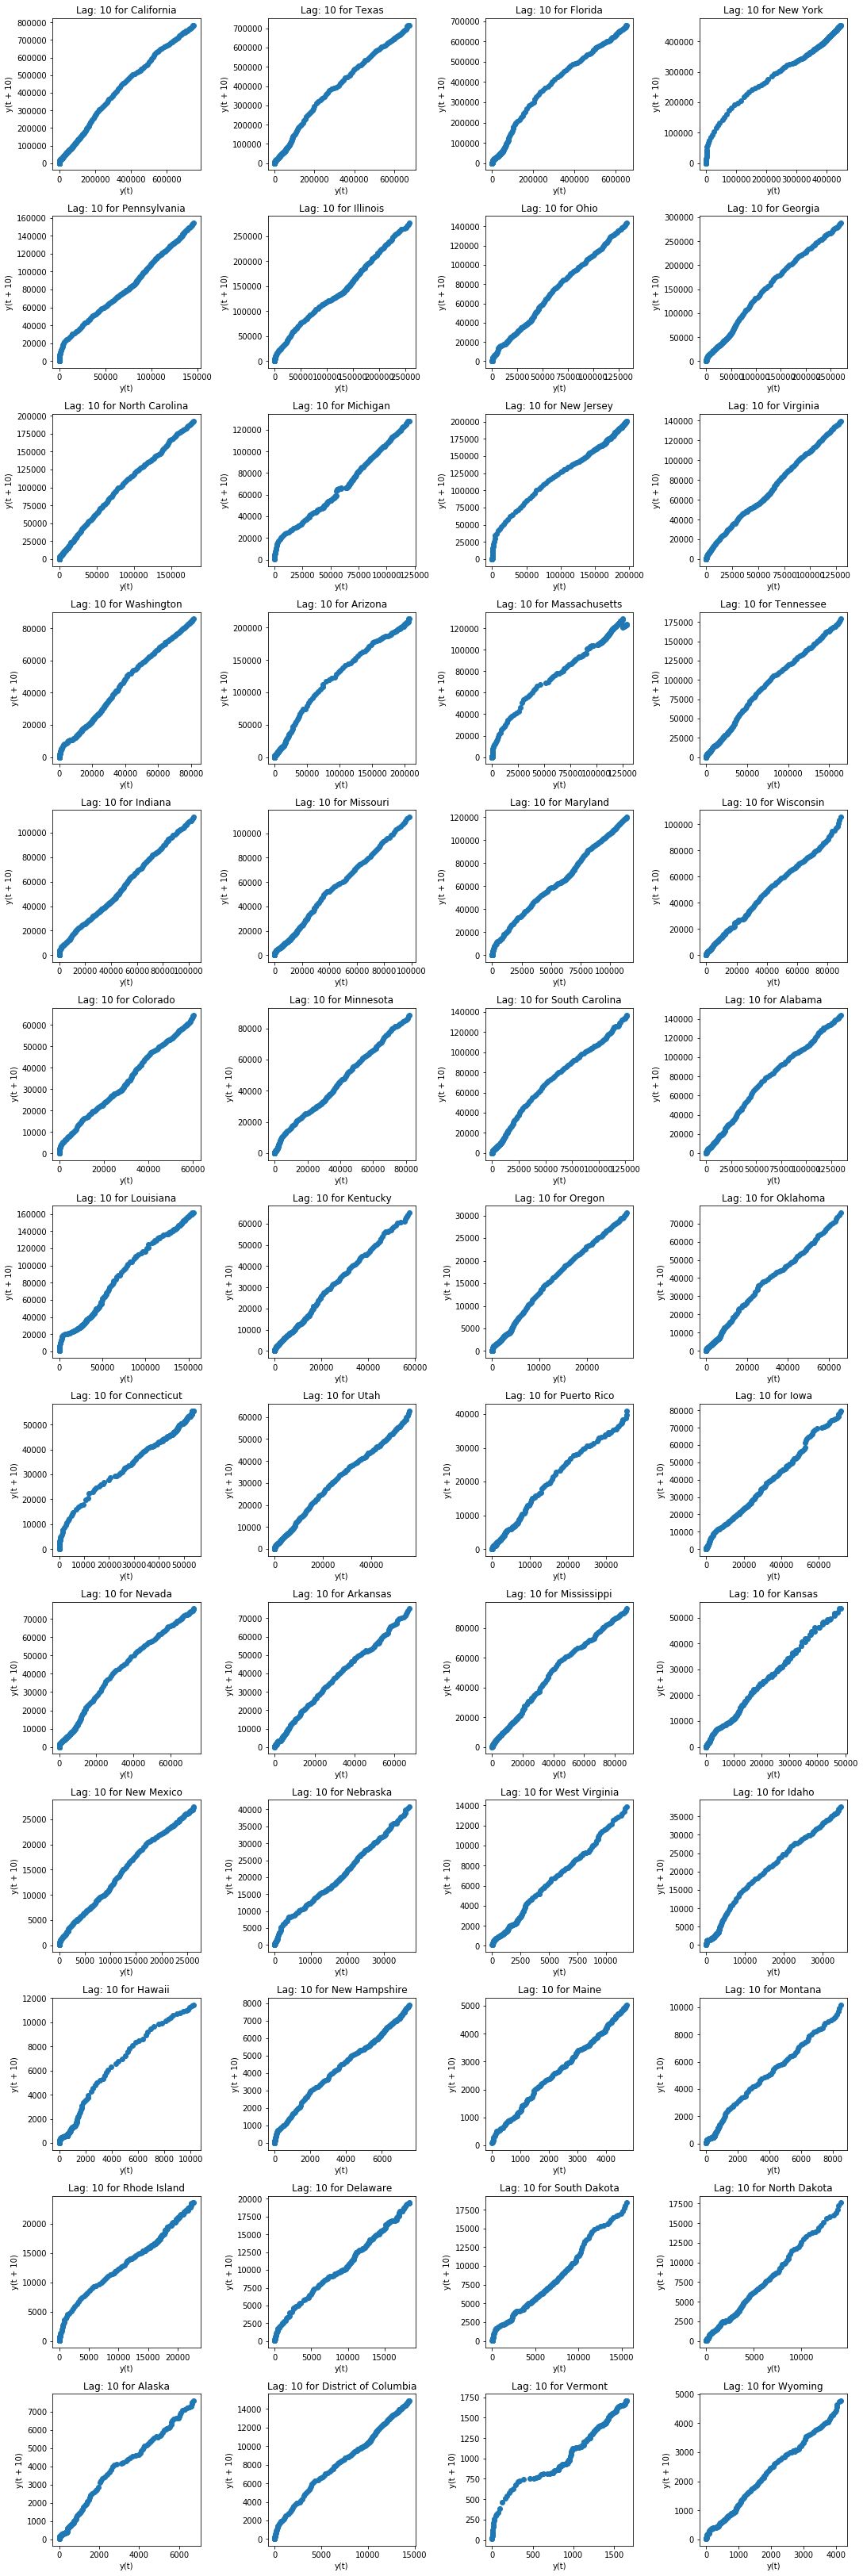

In [43]:
# plot_fn('cases', 'autocorr', **{'sharex': True, 'sharey': True})
plot_fn('cases', 'lag', **{'lag': 10, 'sharex': False, 'sharey': False})

As expected from the type of data and the lag plot, all the states show similar trend. All the states start stabilizing as seen below

Text(0.5, 1.0, 'Deaths')

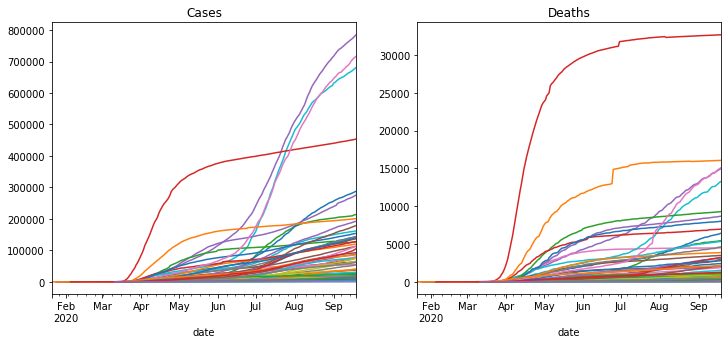

In [57]:
states_df = df.groupby('state')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

states_df.cases.plot(ax=axes[0]);
axes[0].set_title('Cases')
states_df.deaths.plot(ax=axes[1]);
axes[1].set_title('Deaths')

## ARIMA parameters

In [19]:
state_df = df[df.state=='Washington']
state_df

,state,fips,cases,deaths,daily_cases,daily_deaths
date,,,,,,
2020-01-21,Washington,53,1,0,1.0,0.0
2020-01-22,Washington,53,1,0,0.0,0.0
2020-01-23,Washington,53,1,0,0.0,0.0
2020-01-24,Washington,53,1,0,0.0,0.0
2020-01-25,Washington,53,1,0,0.0,0.0
...,...,...,...,...,...,...
2020-09-16,Washington,53,84714,2113,492.0,6.0
2020-09-17,Washington,53,85101,2123,387.0,10.0
2020-09-18,Washington,53,85583,2130,482.0,7.0


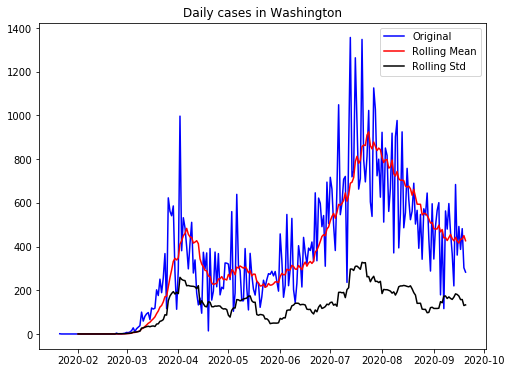

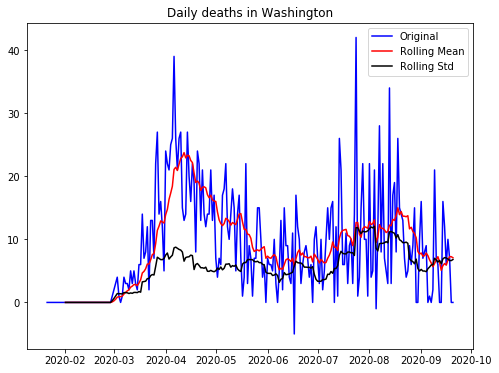

In [20]:
def test_stationarity(timeseries, title, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(8, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Daily {title} in Washington')
    plt.show()
    
test_stationarity(state_df['daily_cases'], title='cases')    
test_stationarity(state_df['daily_deaths'], title='deaths')    

The series is non-seasonal due to limited time observed, but it is non-stationary.

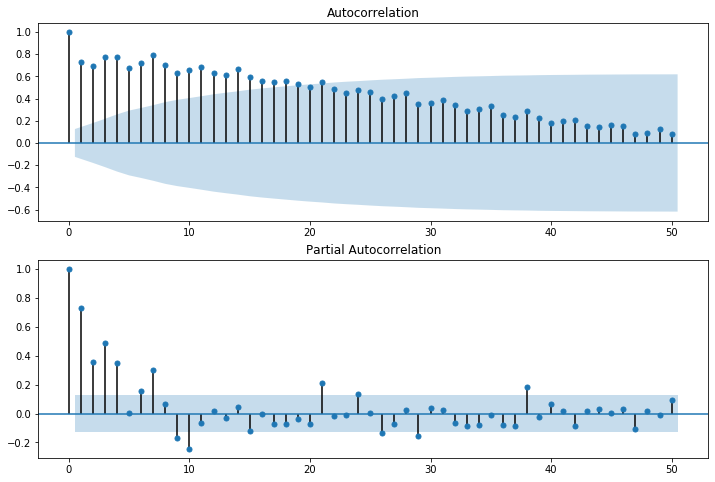

In [21]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(state_df.daily_cases, lags=50, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(state_df.daily_cases, lags=50, ax=ax2)

Here, the PACF displays a sharp cutoff while the ACF decays more slowly. Hence, an AR model will work for our situation with the cutoff being after 5 lag periods in PACF. Also, we have taken a difference over previous 1 period. Thus, the parameters for our time-series is:

|parameter|value|
|---|---|
|p|5|
|d|1|
|q|0|


Refer: https://people.duke.edu/~rnau/411arim3.htm

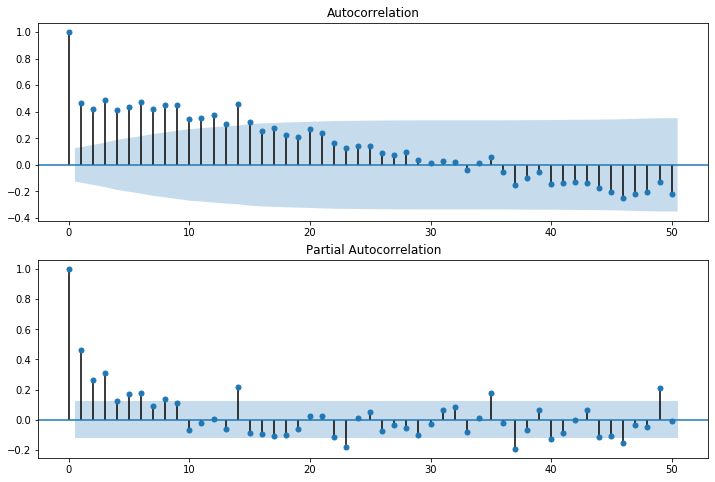

In [22]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(state_df.daily_deaths, lags=50, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(state_df.daily_deaths, lags=50, ax=ax2)

Even for estimation of deaths, we observe similar pattern, with the value of p being 4 instead.

# Model

In [25]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [ ]:
import 

In [26]:
model = ARIMA(state_df.cases, order=(4,1,0))

C:\Users\ksmai\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ksmai\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [75]:
def train(series, split=0.8):
    L = len(series)
    size = int(np.floor(L*split))
    train, test = series[:size], series[size:]
    
    history = list(train)#[x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        ypred = output[0][0]
        predictions.append(ypred)
        obs = test[t]
        history.append(obs)
        print(f'predicted={ypred}, expected={obs}')
        
    error = mean_squared_error(test, predictions)
    print(f'Test MSE: {error:0.3f}')

    return train, test, predictions

results = train(state_df.daily_cases, 0.9)    
# results = train(state_df.cases, 0.9)    

predicted=500.8577120883606, expected=545.0
predicted=473.71366929113805, expected=645.0
predicted=494.3648832201254, expected=437.0
predicted=546.636343956136, expected=288.0
predicted=529.4733554303425, expected=596.0
predicted=554.3499830564905, expected=343.0
predicted=387.5627254724228, expected=493.0
predicted=486.39442815709464, expected=566.0
predicted=474.9614957358789, expected=601.0
predicted=446.8853158546922, expected=179.0
predicted=496.0376784526127, expected=469.0
predicted=541.8508816977696, expected=116.0
predicted=363.93672210772286, expected=563.0
predicted=389.7490338809058, expected=480.0
predicted=367.7118625527148, expected=597.0
predicted=360.18441064538865, expected=465.0
predicted=516.825454010846, expected=367.0
predicted=459.1797162998084, expected=220.0
predicted=493.24496901599275, expected=684.0
predicted=466.77116706254003, expected=361.0
predicted=369.236740135739, expected=492.0
predicted=461.10837289549534, expected=387.0
predicted=487.1982957733184,

In [89]:
train = [1,2,3,7.5,6.5,8.1,7]
model = ARIMA(train, order=(2,1,0))
model_fit = model.fit(disp=0)

test = [7,8,9,10,11]
results = model_fit.forecast(steps=len(test))
# results = model_fit.forecast(steps=1)
results

(array([ 9.13640425,  9.62810706, 11.08755153, 11.99594725, 13.22032887]),
 array([1.60508231, 1.83249002, 2.25931304, 2.50162541, 2.78158488]),
 array([[ 5.99050072, 12.28230777],
        [ 6.03649262, 13.21972151],
        [ 6.65937934, 15.51572372],
        [ 7.09285155, 16.89904295],
        [ 7.76852269, 18.67213505]]))

In [108]:
a = np.arange(4)
np.insert(a,1,9)
a

array([0, 1, 2, 3])

In [110]:
a = np.arange(5)

bounds = np.array([[ 5.99050072, 12.28230777],
        [ 6.03649262, 13.21972151],
        [ 6.65937934, 15.51572372],
        [ 7.09285155, 16.89904295],
        [ 7.76852269, 18.67213505]])

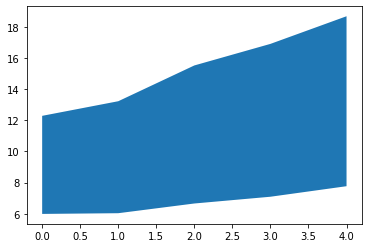

In [111]:
plt.fill_between(a, bounds[:,0], bounds[:,1])    


(5, 2)


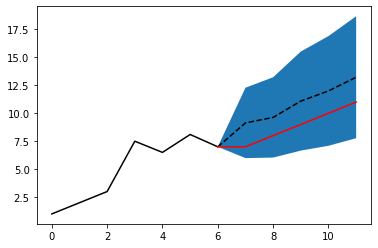

In [113]:
def plot_curve(train, test, results):
    pred, stderr, bounds = results
    
    xticks = list(range(len(train)+len(test))) # Temporary
    print(bounds.shape)#[:,0])
    
    # To merge with first column
    test = np.insert(test, 0, train[-1])
    pred = np.insert(pred, 0, train[-1])
    bounds = np.insert(bounds, 0, train[-1], axis=0)   # insert 0 at 0th row
#     print(bounds)#[:,0])
    plt.plot(xticks[:len(train)], train, 'k')
    plt.plot(xticks[len(train)-1:], pred, '--k')    
    plt.plot(xticks[len(train)-1:], test, 'r')    
    plt.fill_between(xticks[len(train)-1:], bounds[:,0], bounds[:,1])    
    
plot_curve(train, test, results)    

In [43]:
model.forecast()

AttributeError: 'ARIMA' object has no attribute 'forecast'